# Тестовое для СДЕК летней стажировки

Задача:
Предсказать цену (price) на аренду жилья, используя не только табличные данные, но и координаты.

Сслыка: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/data

In [1]:
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# scikit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Функции

Функция для рассчёта интерквартильного размаха (IQR)

In [2]:
def calculate_iqr(column: pd.Series) -> tuple[float, float]:
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_q = Q1 - 1.5 * IQR
    upper_q = Q3 + 1.5 * IQR
    
    return lower_q, upper_q

Функция для обучения RandomForest моделей.

In [3]:
def train(in_df, n_estimators, max_depth):
    X = in_df.drop(["price"], axis=1)
    y = in_df["price"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

    model.fit(X_train, y_train)
    joblib.dump(model, "mode.plk")

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    print("On test:")
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")

    print("\nOn train:")
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2 = r2_score(y_train, y_pred_train)
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")
    print()

    feature_importances = model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    return model, importance_df

Функция очищает лишние признаки на основе переданного порога.

In [4]:
def delete_unimportant(in_df, imp_df, threshold):
    features_to_remove = imp_df[imp_df['Importance'] < threshold]['Feature'].tolist()
    print(imp_df[imp_df["Importance"] >= threshold])

    df_dropped = in_df.drop(features_to_remove, axis=1)
    
    return df_dropped


## Анализ

Открываем таблицу и просматриваем количество записей, а также колонки (признаки) для анализа.

In [5]:
TOTAL_DELITIONS = 0

origin_df = pd.read_csv("data/AB_NYC_2019.csv")
df = origin_df.copy()

print("Total lines:", df.shape[0])
print("Columns:")
for col in df.columns:
    print(" -", col)

Total lines: 48895
Columns:
 - id
 - name
 - host_id
 - host_name
 - neighbourhood_group
 - neighbourhood
 - latitude
 - longitude
 - room_type
 - price
 - minimum_nights
 - number_of_reviews
 - last_review
 - reviews_per_month
 - calculated_host_listings_count
 - availability_365


### Анализ цен

In [6]:
column = df["price"]

print("Origin stat:")
print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

print("\nLess or equal zero price elements:", len(column[column <= 0]))
df = df[column > 0]
column = df["price"]

l, u = calculate_iqr(column)
print("IQR range:", l, u)

print("\nNormal stat:")
iqr_mask_normal = (column >= l) & (column <= u)
print("Min:", column[iqr_mask_normal].min())
print("Max:", column[iqr_mask_normal].max())
print("Mean:", column[iqr_mask_normal].mean())

print("\nEmissions stat:")
iqr_mask_emissions = column > u
print("Min:", column[iqr_mask_emissions].min())
print("Max:", column[iqr_mask_emissions].max())
print("Mean:", column[iqr_mask_emissions].mean())

print(f"\nNormal values share: {(len(column[iqr_mask_normal]) / len(column) * 100):.3f}%")


Origin stat:
Min: 0
Max: 10000
Mean: 152.7206871868289

Less or equal zero price elements: 11
IQR range: -90.0 334.0

Normal stat:
Min: 10
Max: 334
Mean: 119.99906342568391

Emissions stat:
Min: 335
Max: 10000
Mean: 658.7755720053835

Normal values share: 93.920%


Из вывода можно понять, что в таблице были предложения с ценой в 0 долларов, что является ошибочными значениями, отбрасываем их.
Также можно заметить, что максимальное значение цены сильно больше среднего, что свидетельствует о выбросах. Для того, чтобы отсеять их подсчитаем IQR.
Увдим, что в столбце действительно имеются выбросы, а именно значения больше 334 долларов. Доля нормальных значений ~94%.

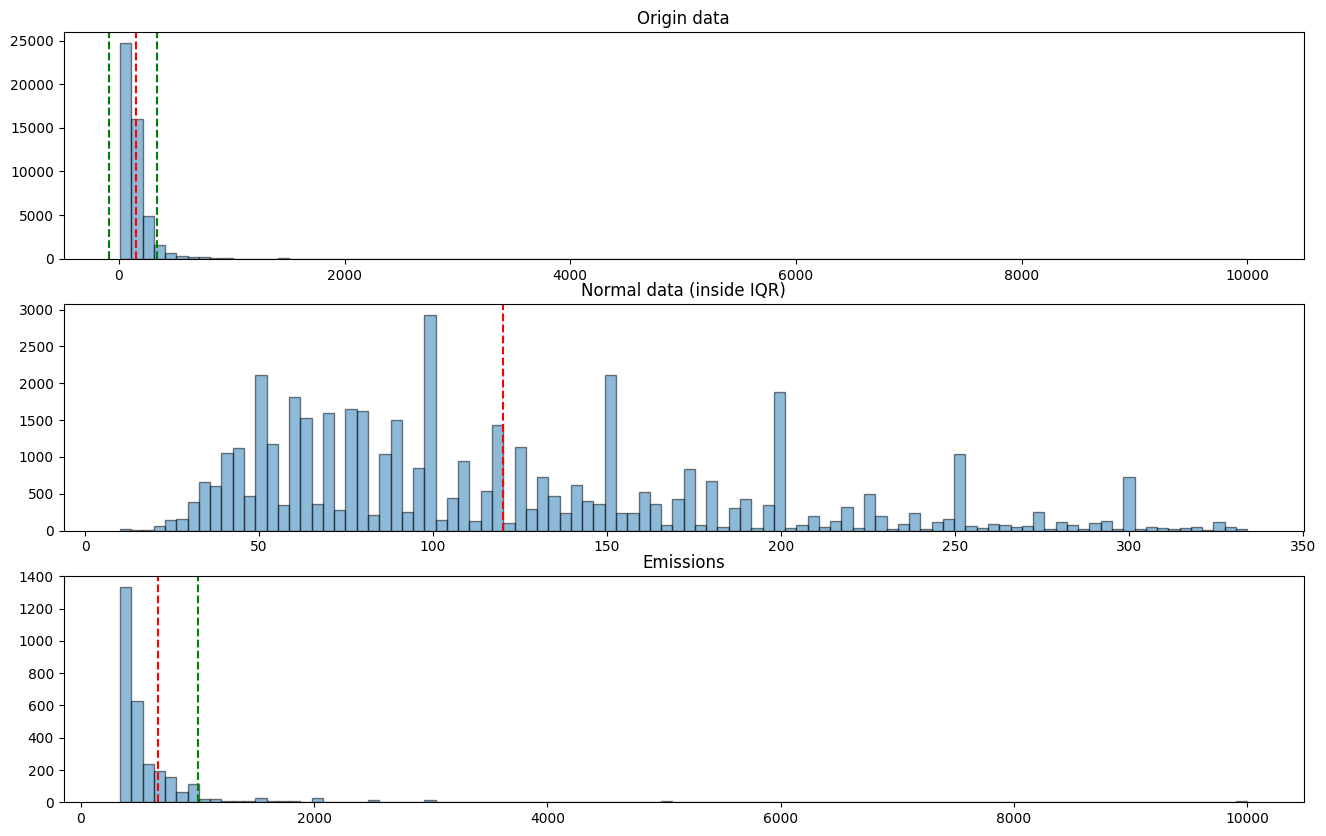

In [7]:
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor='black')
ax[0].axvline(x=l, color='green', linestyle='--')
ax[0].axvline(x=u, color='green', linestyle='--')
ax[0].axvline(x=column.mean(), color='red', linestyle='--')

col = column[iqr_mask_normal]
ax[1].set_title("Normal data (inside IQR)")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor='black')
ax[1].axvline(x=col.mean(), color='red', linestyle='--')

col = column[iqr_mask_emissions]
ax[2].set_title("Emissions")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor='black')
ax[2].axvline(x=col.mean(), color='red', linestyle='--')
ax[2].axvline(x=1000, color='green', linestyle='--')

plt.show()

Из третьего графика можно заметить, что значения до 1000 долларов могут встречаться достаточно часто, нужно попробовать включить их в нормальный дииапазон ии проверить.

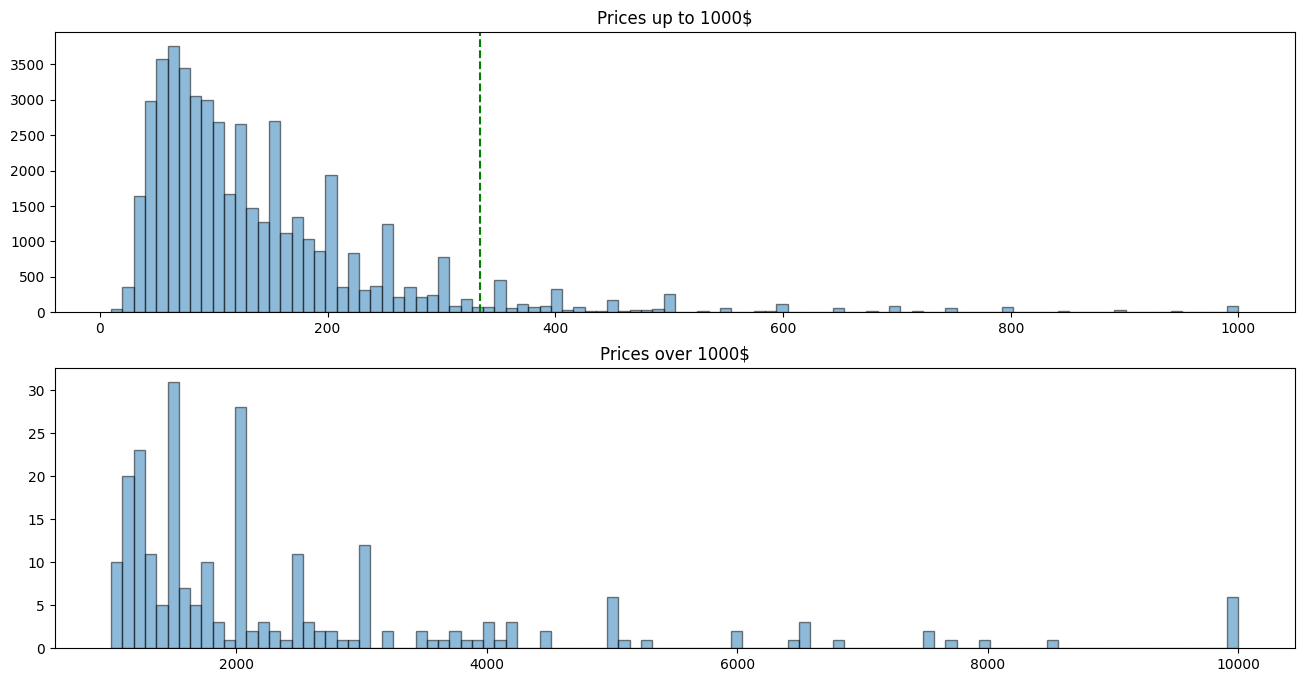

In [8]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

col = column[column <= 1000]
ax[0].set_title("Prices up to 1000$")
ax[0].hist(col, bins=100, alpha=0.5, edgecolor='black')
ax[0].axvline(x=u, color="green", linestyle="--")

col = column[column > 1000]
ax[1].set_title("Prices over 1000$")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor='black')

plt.show()

Из более точной гистограммы видно, что суммы от Q3 до 1000 долларов всё-таки достаточно разрежены, и являются выбросами.

В дальнейшем имеет смысл анализировать выбросы отдельно, но пока мы их просто отбросим.

In [9]:
to_delition = len(df[iqr_mask_emissions])
print("Count of elements to deletion:", to_delition)
TOTAL_DELITIONS += to_delition

df_tmp = df[iqr_mask_normal]
print("Final values:")
print("Min:", df_tmp["price"].min())
print("Max:", df_tmp["price"].max())
print("Mean:", df_tmp["price"].mean())

price_mask = iqr_mask_normal

Count of elements to deletion: 2972
Final values:
Min: 10
Max: 334
Mean: 119.99906342568391


### Анализ колонок арендодателей

In [10]:
column = df["host_id"]
print("Total host IDs:", len(column.unique()))
print(f"Unique ID shape: {(len(column.unique()) / df.shape[0] * 100):.3f}%")

Total host IDs: 37455
Unique ID shape: 76.620%


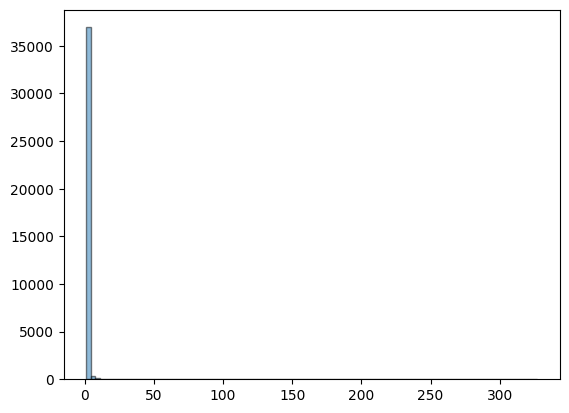

In [11]:
uni = column.value_counts()

plt.hist(uni, bins=100, alpha=0.5, edgecolor="black")
plt.show()

Всего в таблице 35387 уникальных ID, при этом они занимают 77% от общего количества записей в таблице. При отсутвии баланса количества помещений на одного арендодателя получается, что нет особого смысла учитывать колонки host в модели.
Учёт ID арендодателя может помочь при рассчёте стоимости жилья, так как может быть корелляция между предложениями арендодателя и ценой жилья, но в данном случае учёт ID будет мешать.

In [12]:
# Удаление лишних колонок
df = df.drop(["name", "host_id", "host_name"], axis=1)

### Время простоя жилья

IQR range: -340.5 567.5
Count of '0' values 17530
Count of '365' values: 1295


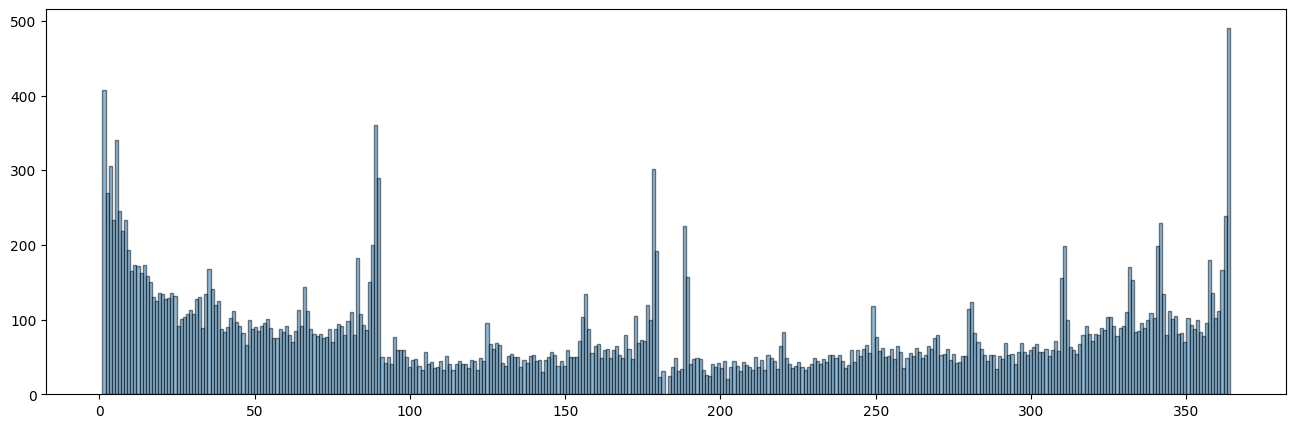

In [13]:
column = df["availability_365"]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

l, u = calculate_iqr(column)
print("IQR range:", l, u)

print("Count of '0' values", column.value_counts()[0])
print("Count of '365' values:", column.value_counts()[365])
ax.hist(column[(column != 0) & (column != 365)], bins=365, alpha=0.5, edgecolor="black")

plt.show()

* Данные о простое в 0 и 365 дней не отображены на гистограмме, так они преобладают, что заструдняло рассмотрение графика.

По анализу IQR данные не содержат выбросов и вцелом достачно сбалансированны, никакие значения отбршены не будут.

### Минимальное количество ночей

Min: 1
Max: 1250
Mean: 7.029887079617053

IQR range: -5.0 11.0


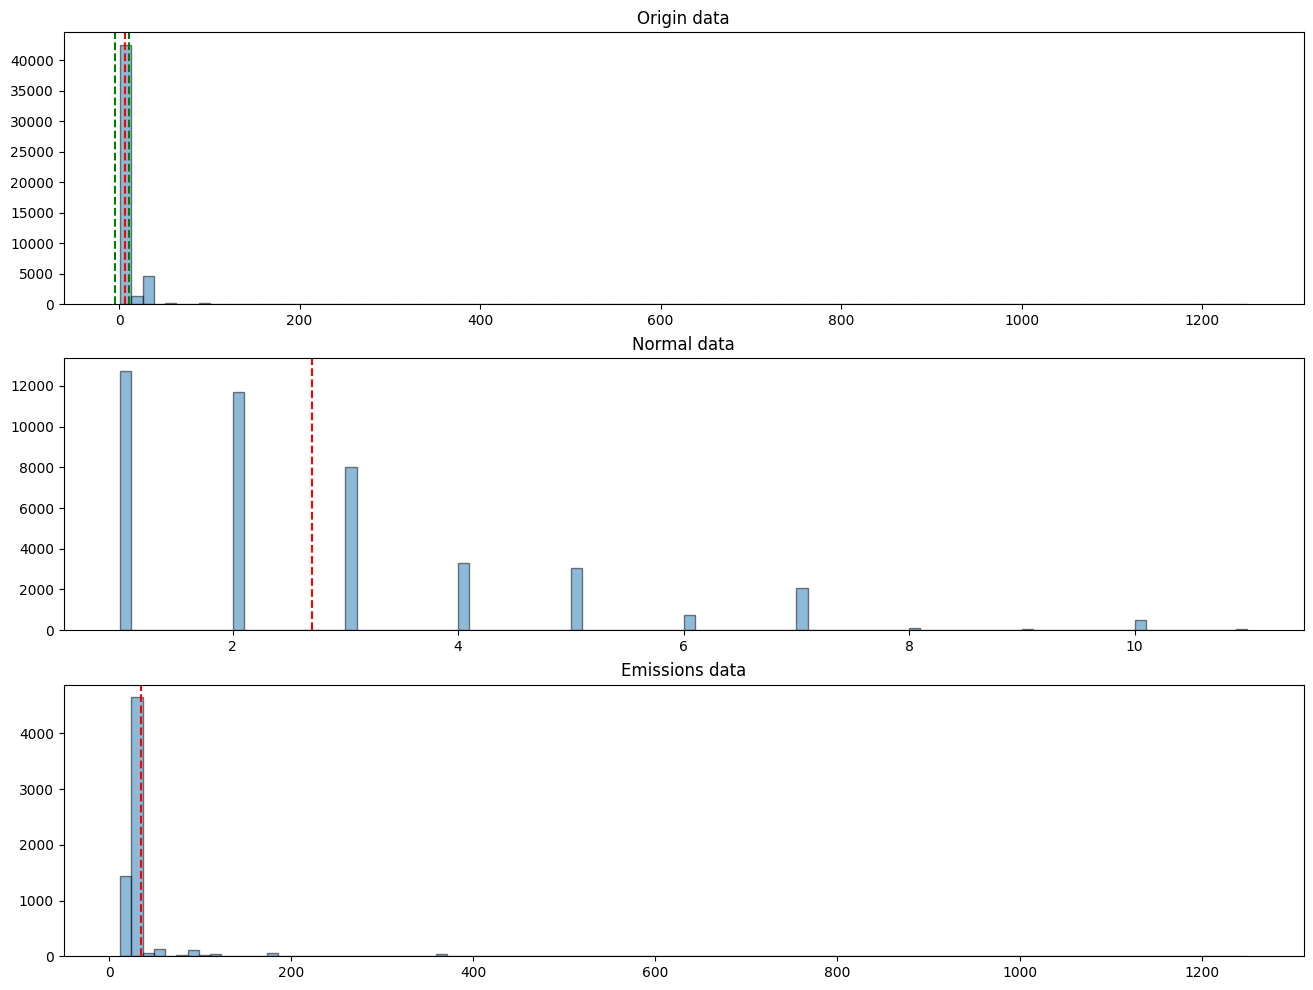

In [14]:
column = df["minimum_nights"]

print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)

_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor="black")
ax[0].axvline(x=l, color="green", linestyle="--")
ax[0].axvline(x=u, color="green", linestyle="--")
ax[0].axvline(x=column.mean(), color="red", linestyle="--")

col = column[column <= u]
ax[1].set_title("Normal data")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[1].axvline(x=col.mean(), color="red", linestyle="--")

col = column[column > u]
ax[2].set_title("Emissions data")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[2].axvline(x=col.mean(), color="red", linestyle="--")

plt.show()

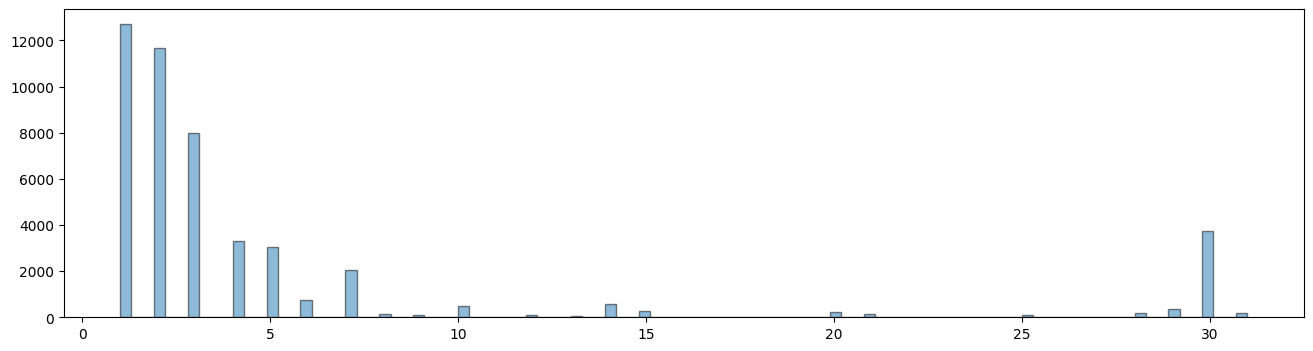

In [15]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

col = column[column <= 31]
ax.hist(col, bins=100, alpha=0.5, edgecolor="black")

plt.show()

Больше одного месяца скорее всего выбросы, т.к. больше месяца минимальное количество ночей обычно не бывает.

In [16]:
to_delition = len(column[column > 31])
print("Elements count to deletion:", to_delition)
TOTAL_DELITIONS += to_delition

df = df[df["minimum_nights"] <= 31]

Elements count to deletion: 546


### Количество объявлений

Min: 1
Max: 327
Mean: 7.144730853572758

IQR range: -0.5 3.5


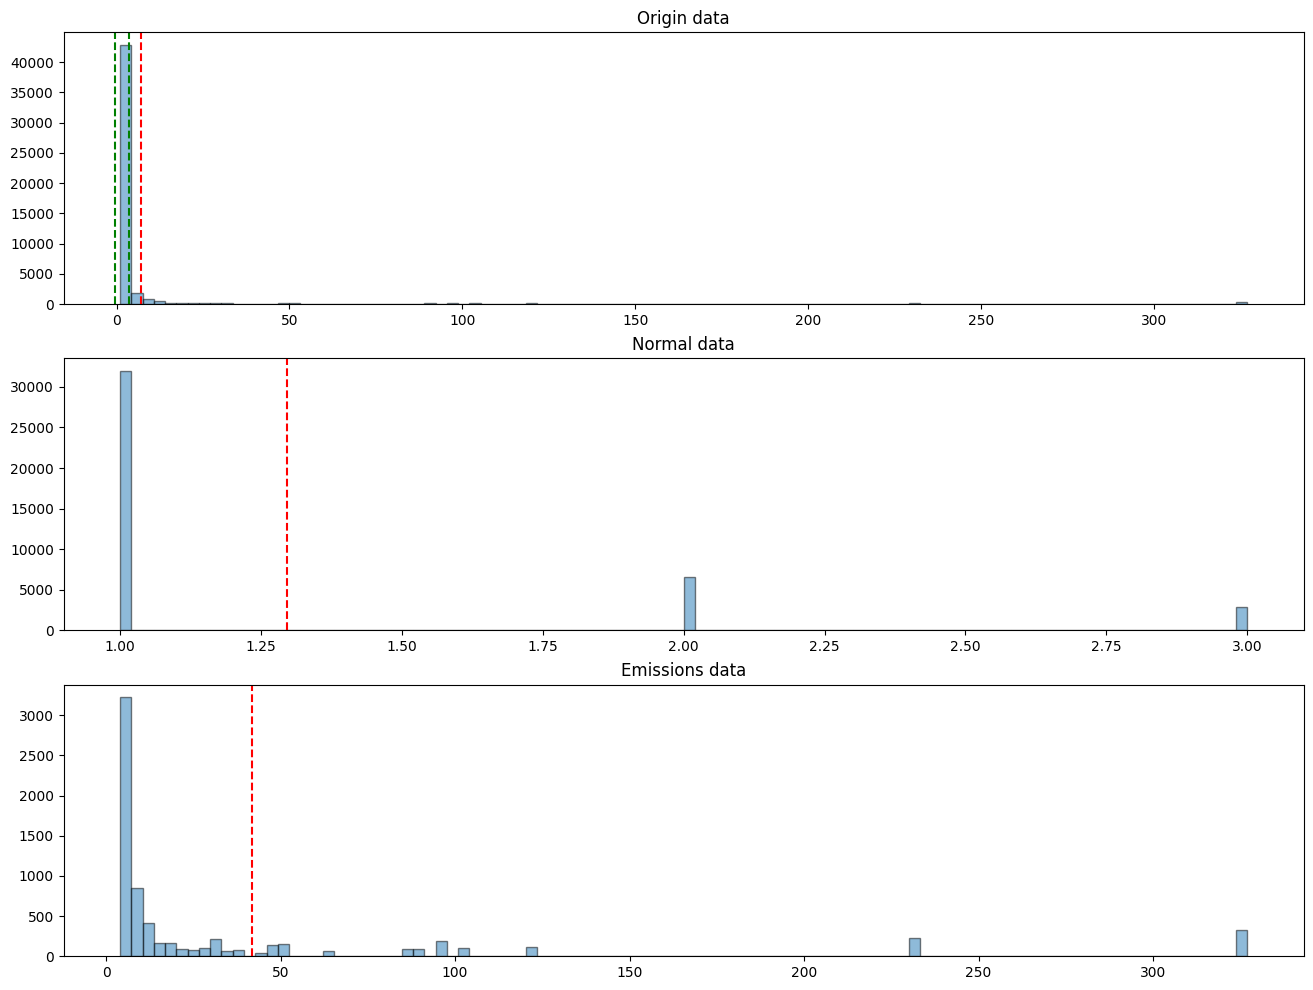

In [17]:
column = df["calculated_host_listings_count"]

print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)

_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor="black")
ax[0].axvline(x=l, color="green", linestyle="--")
ax[0].axvline(x=u, color="green", linestyle="--")
ax[0].axvline(x=column.mean(), color="red", linestyle="--")

col = column[column <= u]
ax[1].set_title("Normal data")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[1].axvline(x=col.mean(), color="red", linestyle="--")

col = column[column > u]
ax[2].set_title("Emissions data")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[2].axvline(x=col.mean(), color="red", linestyle="--")

plt.show()

Диапазон значений выглядит нормально, но данные крайне несбалансированы, пока ничего не будет удалено, но необходимо проверить, будет ли улучшение при частичном удалении элементов, или полного удаления признака.

### Отзывы
Колонки:
 - number_of_reviews
 - last_review
 - reviews_per_month

Min: 0
Max: 629
Mean: 23.418387190202324
Count of zeros: 9805

IQR range: -42.0 78.0


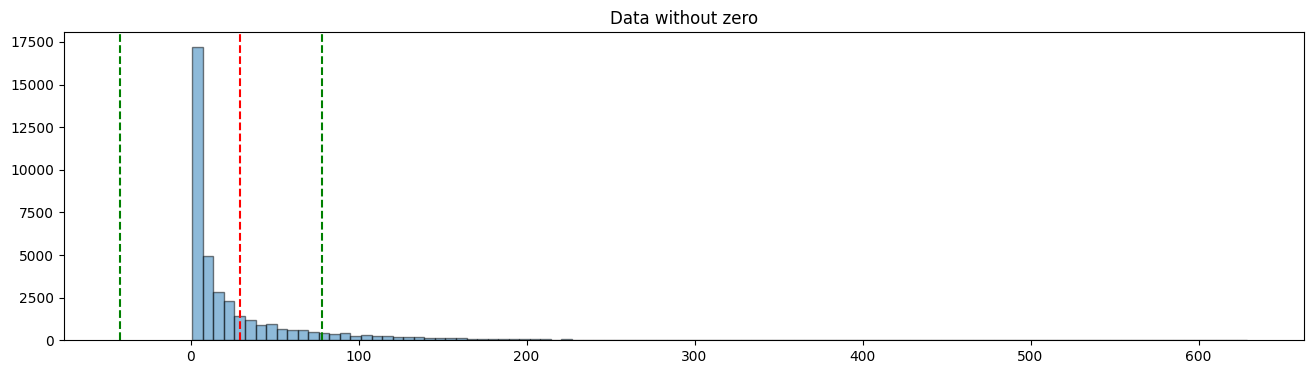

In [18]:
column = df["number_of_reviews"]

print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())
print("Count of zeros:", len(column[column == 0]))

column = column[column > 0]

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

ax.set_title("Data without zero")
ax.hist(column, bins=100, alpha=0.5, edgecolor="black")
ax.axvline(x=l, color="green", linestyle="--")
ax.axvline(x=u, color="green", linestyle="--")
ax.axvline(x=column.mean(), color="red", linestyle="--")

plt.show()

In [19]:
column = pd.to_datetime(df["last_review"])

print("Min date:", column.min())
print("Max date:", column.max())
print("Count of Null:", len(column[column.isna()]))

column = column.fillna(column.min())
column = column.max() - column
column = column.apply(lambda x: x.days)

Min date: 2011-03-28 00:00:00
Max date: 2019-07-08 00:00:00
Count of Null: 9805


Min: 0
Max: 3024
Mean: 832.8073772187513

IQR range: -1712.0 2904.0
Count of emissions: 9808


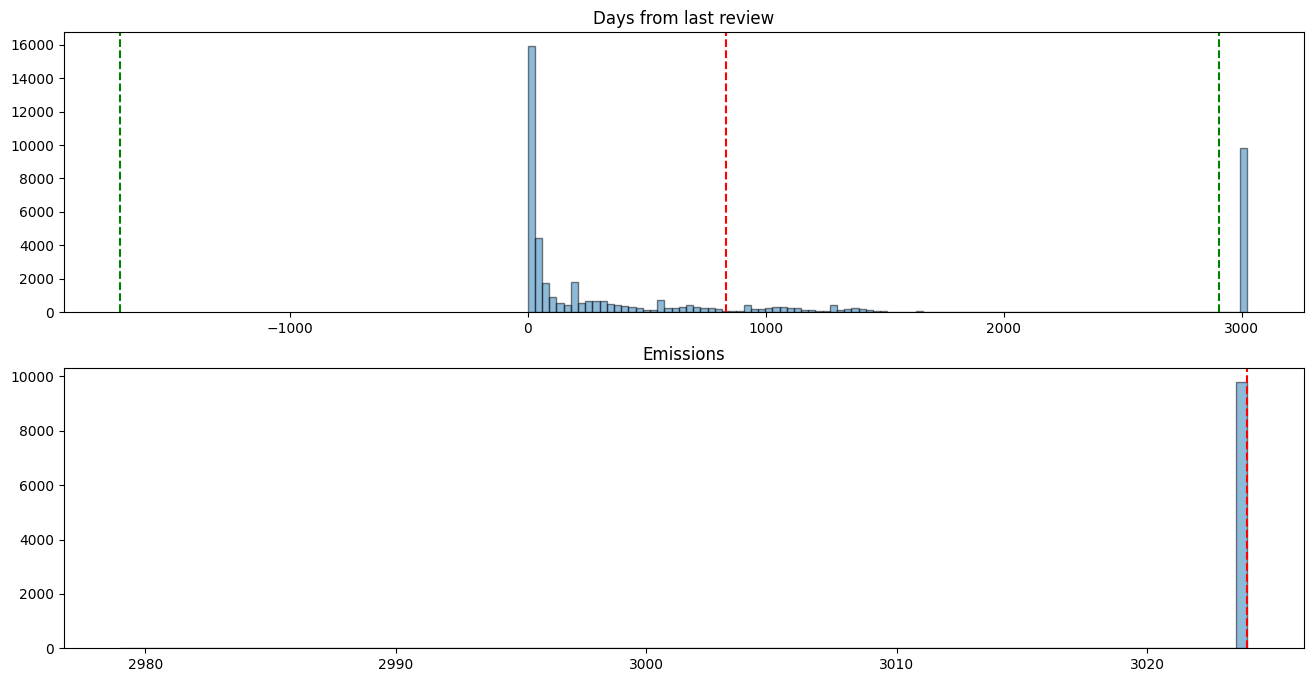

In [20]:
print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)
print("Count of emissions:", len(column[column > u]))

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

ax[0].set_title("Days from last review")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor="black")
ax[0].axvline(x=l, color="green", linestyle="--")
ax[0].axvline(x=u, color="green", linestyle="--")
ax[0].axvline(x=column.mean(), color="red", linestyle="--")

col = column[column > u]
ax[1].set_title("Emissions")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[1].axvline(x=col.mean(), color="red", linestyle="--")

df["last_review"] = column

plt.show()

Min: 0.01
Max: 58.5
Mean: 1.3803703319232865

IQR range: -2.57 4.789999999999999


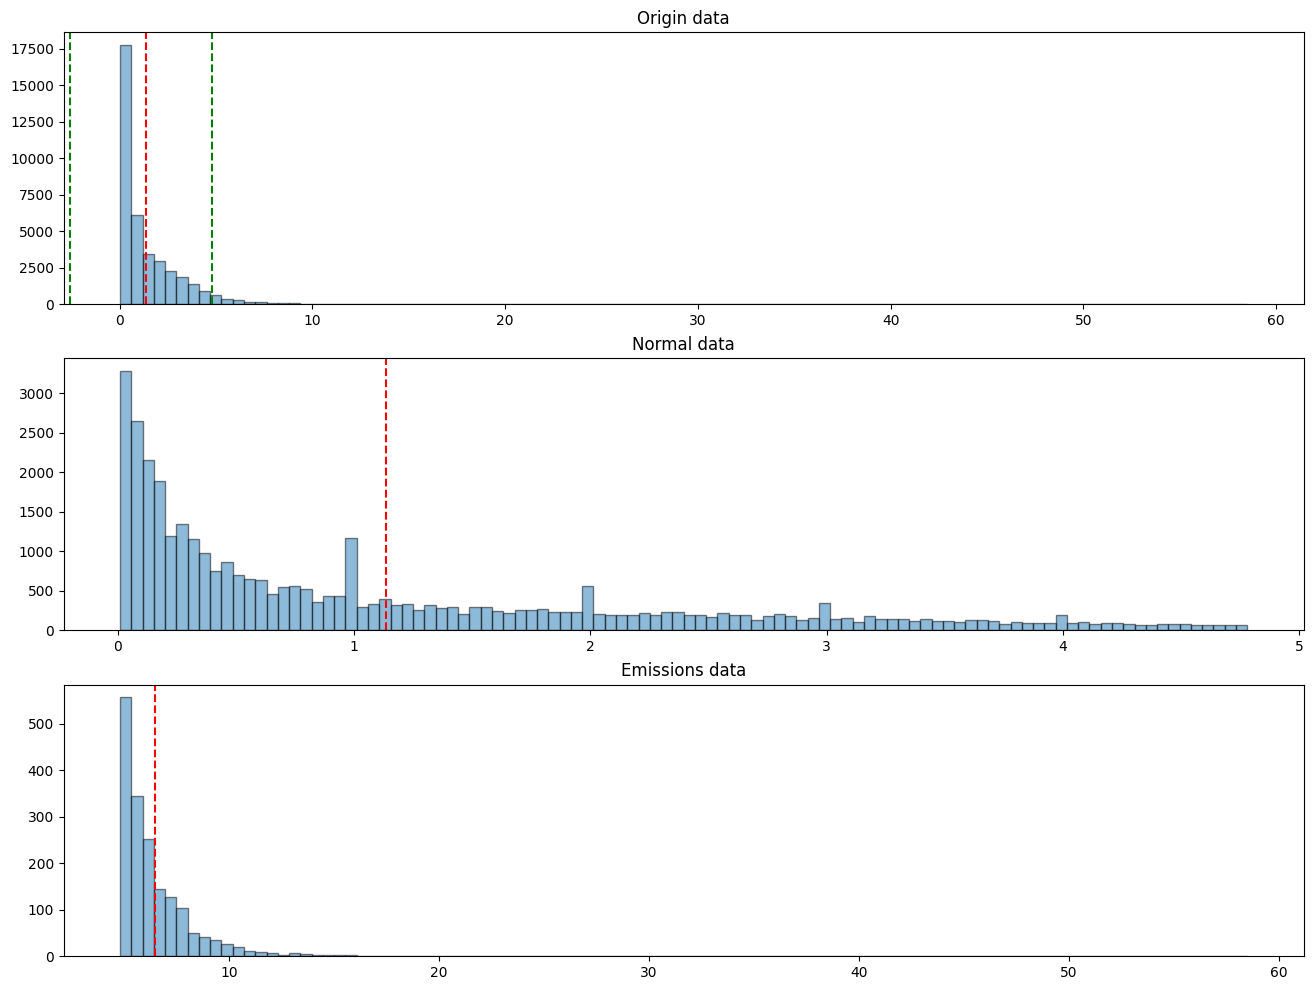

In [21]:
column = df["reviews_per_month"]

print("Min:", column.min())
print("Max:", column.max())
print("Mean:", column.mean())

l, u = calculate_iqr(column)
print("\nIQR range:", l, u)

_, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

ax[0].set_title("Origin data")
ax[0].hist(column, bins=100, alpha=0.5, edgecolor="black")
ax[0].axvline(x=l, color="green", linestyle="--")
ax[0].axvline(x=u, color="green", linestyle="--")
ax[0].axvline(x=column.mean(), color="red", linestyle="--")

col = column[column <= u]
ax[1].set_title("Normal data")
ax[1].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[1].axvline(x=col.mean(), color="red", linestyle="--")

col = column[column > u]
ax[2].set_title("Emissions data")
ax[2].hist(col, bins=100, alpha=0.5, edgecolor="black")
ax[2].axvline(x=col.mean(), color="red", linestyle="--")

plt.show()

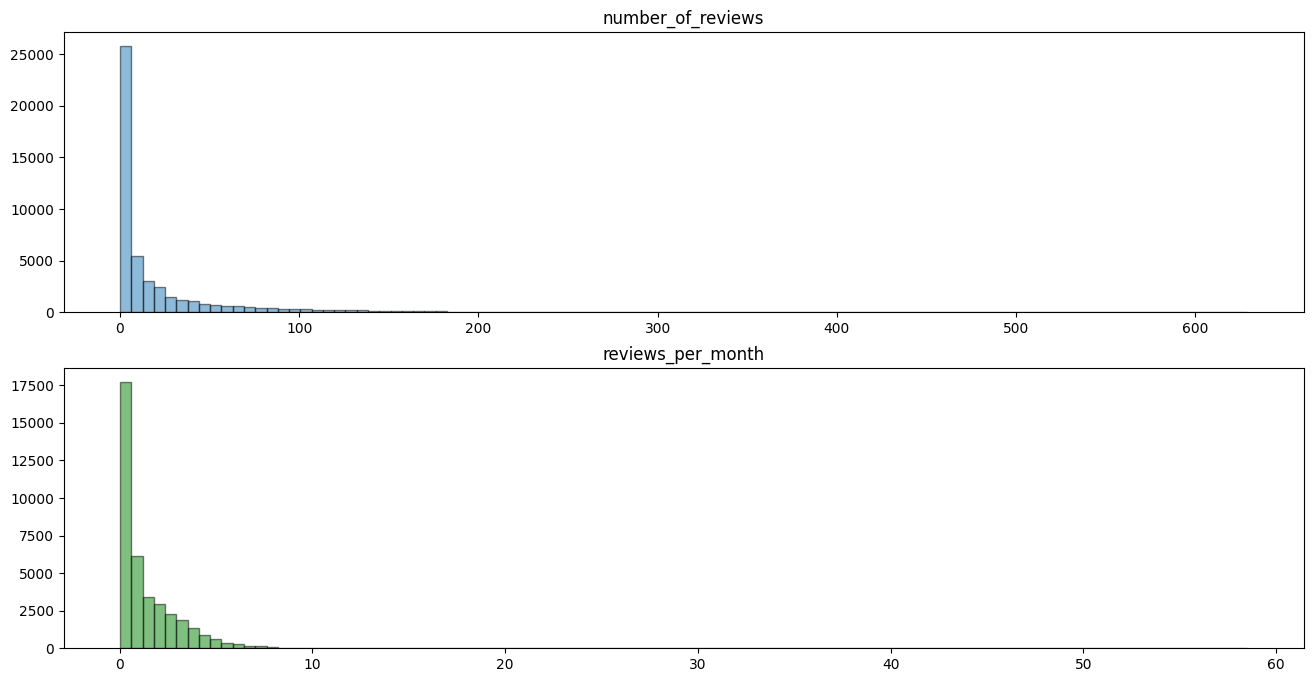

In [22]:
reviews_count = df["number_of_reviews"]
reviews_per_month = df["reviews_per_month"]

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

ax[0].set_title("number_of_reviews")
ax[0].hist(reviews_count, bins=100, alpha=0.5, edgecolor="black")
ax[1].set_title("reviews_per_month")
ax[1].hist(reviews_per_month, color="green", bins=100, alpha=0.5, edgecolor="black")

plt.show()

По графикам видно, что, во-первых, большая часть дат находится в IQR, и в выбросы попалии только те строки, где отзывы были очень давно, либо их небыло. Так как отсутвие отзывов тоже может влиять на цену жилья, эта часть значений не будет отброшена. И во-вторых, видно, что значения number_of_reviews и reviews_per_month имеют схожие рспеделения несут одну и ту же информацию, поэтому имеет смысл откинуть один из параметров. Будут использоваться именно количество отзывов в месяц, так как оно несёт больше информации о востребованности предложения.

In [23]:
df = df.drop(["number_of_reviews"], axis=1)

### Расположение и тип помещения
Колонки:
- room_type
- neighbourhood
- neighbourhood_group

In [24]:
print("Room types count:", len(df["room_type"].unique()))
print("Neighbourhoods count:", len(df["neighbourhood"].unique()))
print("Neighbourhood groups count:", len(df["neighbourhood_group"].unique()))

Room types count: 3
Neighbourhoods count: 221
Neighbourhood groups count: 5


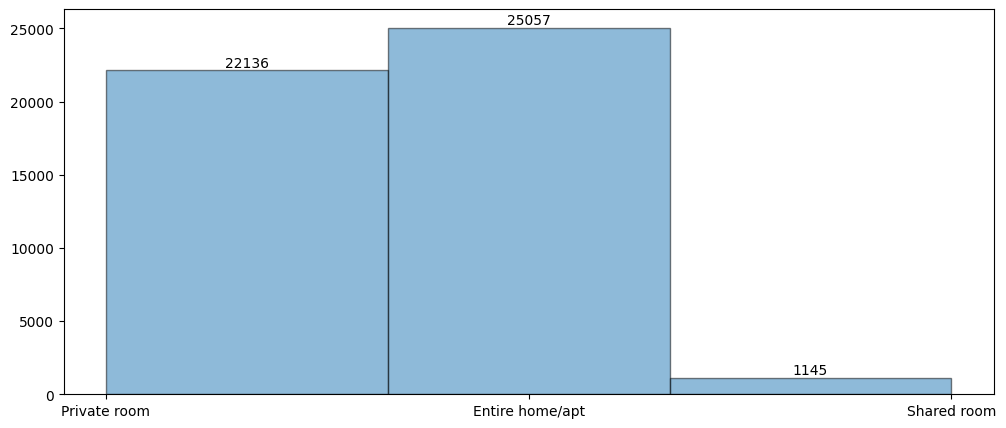

In [25]:
column = df["room_type"]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

n, bins, patches = ax.hist(column, bins=3, alpha=0.5, edgecolor="black")

for i in range(len(patches)):
    plt.text(bins[i] + (bins[1]-bins[0])/2,
             n[i],
             str(int(n[i])),
             ha="center",
             va="bottom") 

plt.show()

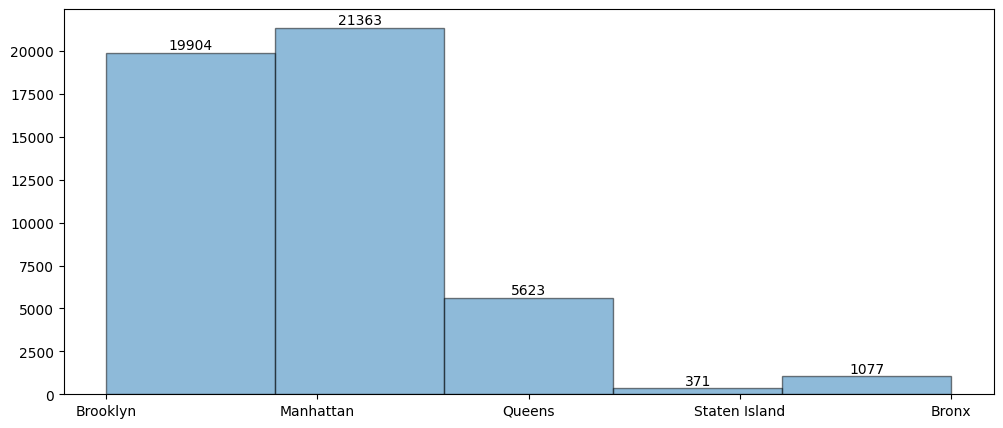

In [26]:
column = df["neighbourhood_group"]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

n, bins, patches = ax.hist(column, bins=5, alpha=0.5, edgecolor="black")

for i in range(len(patches)):
    plt.text(bins[i] + (bins[1]-bins[0])/2,
             n[i],
             str(int(n[i])),
             ha="center",
             va="bottom") 

plt.show()

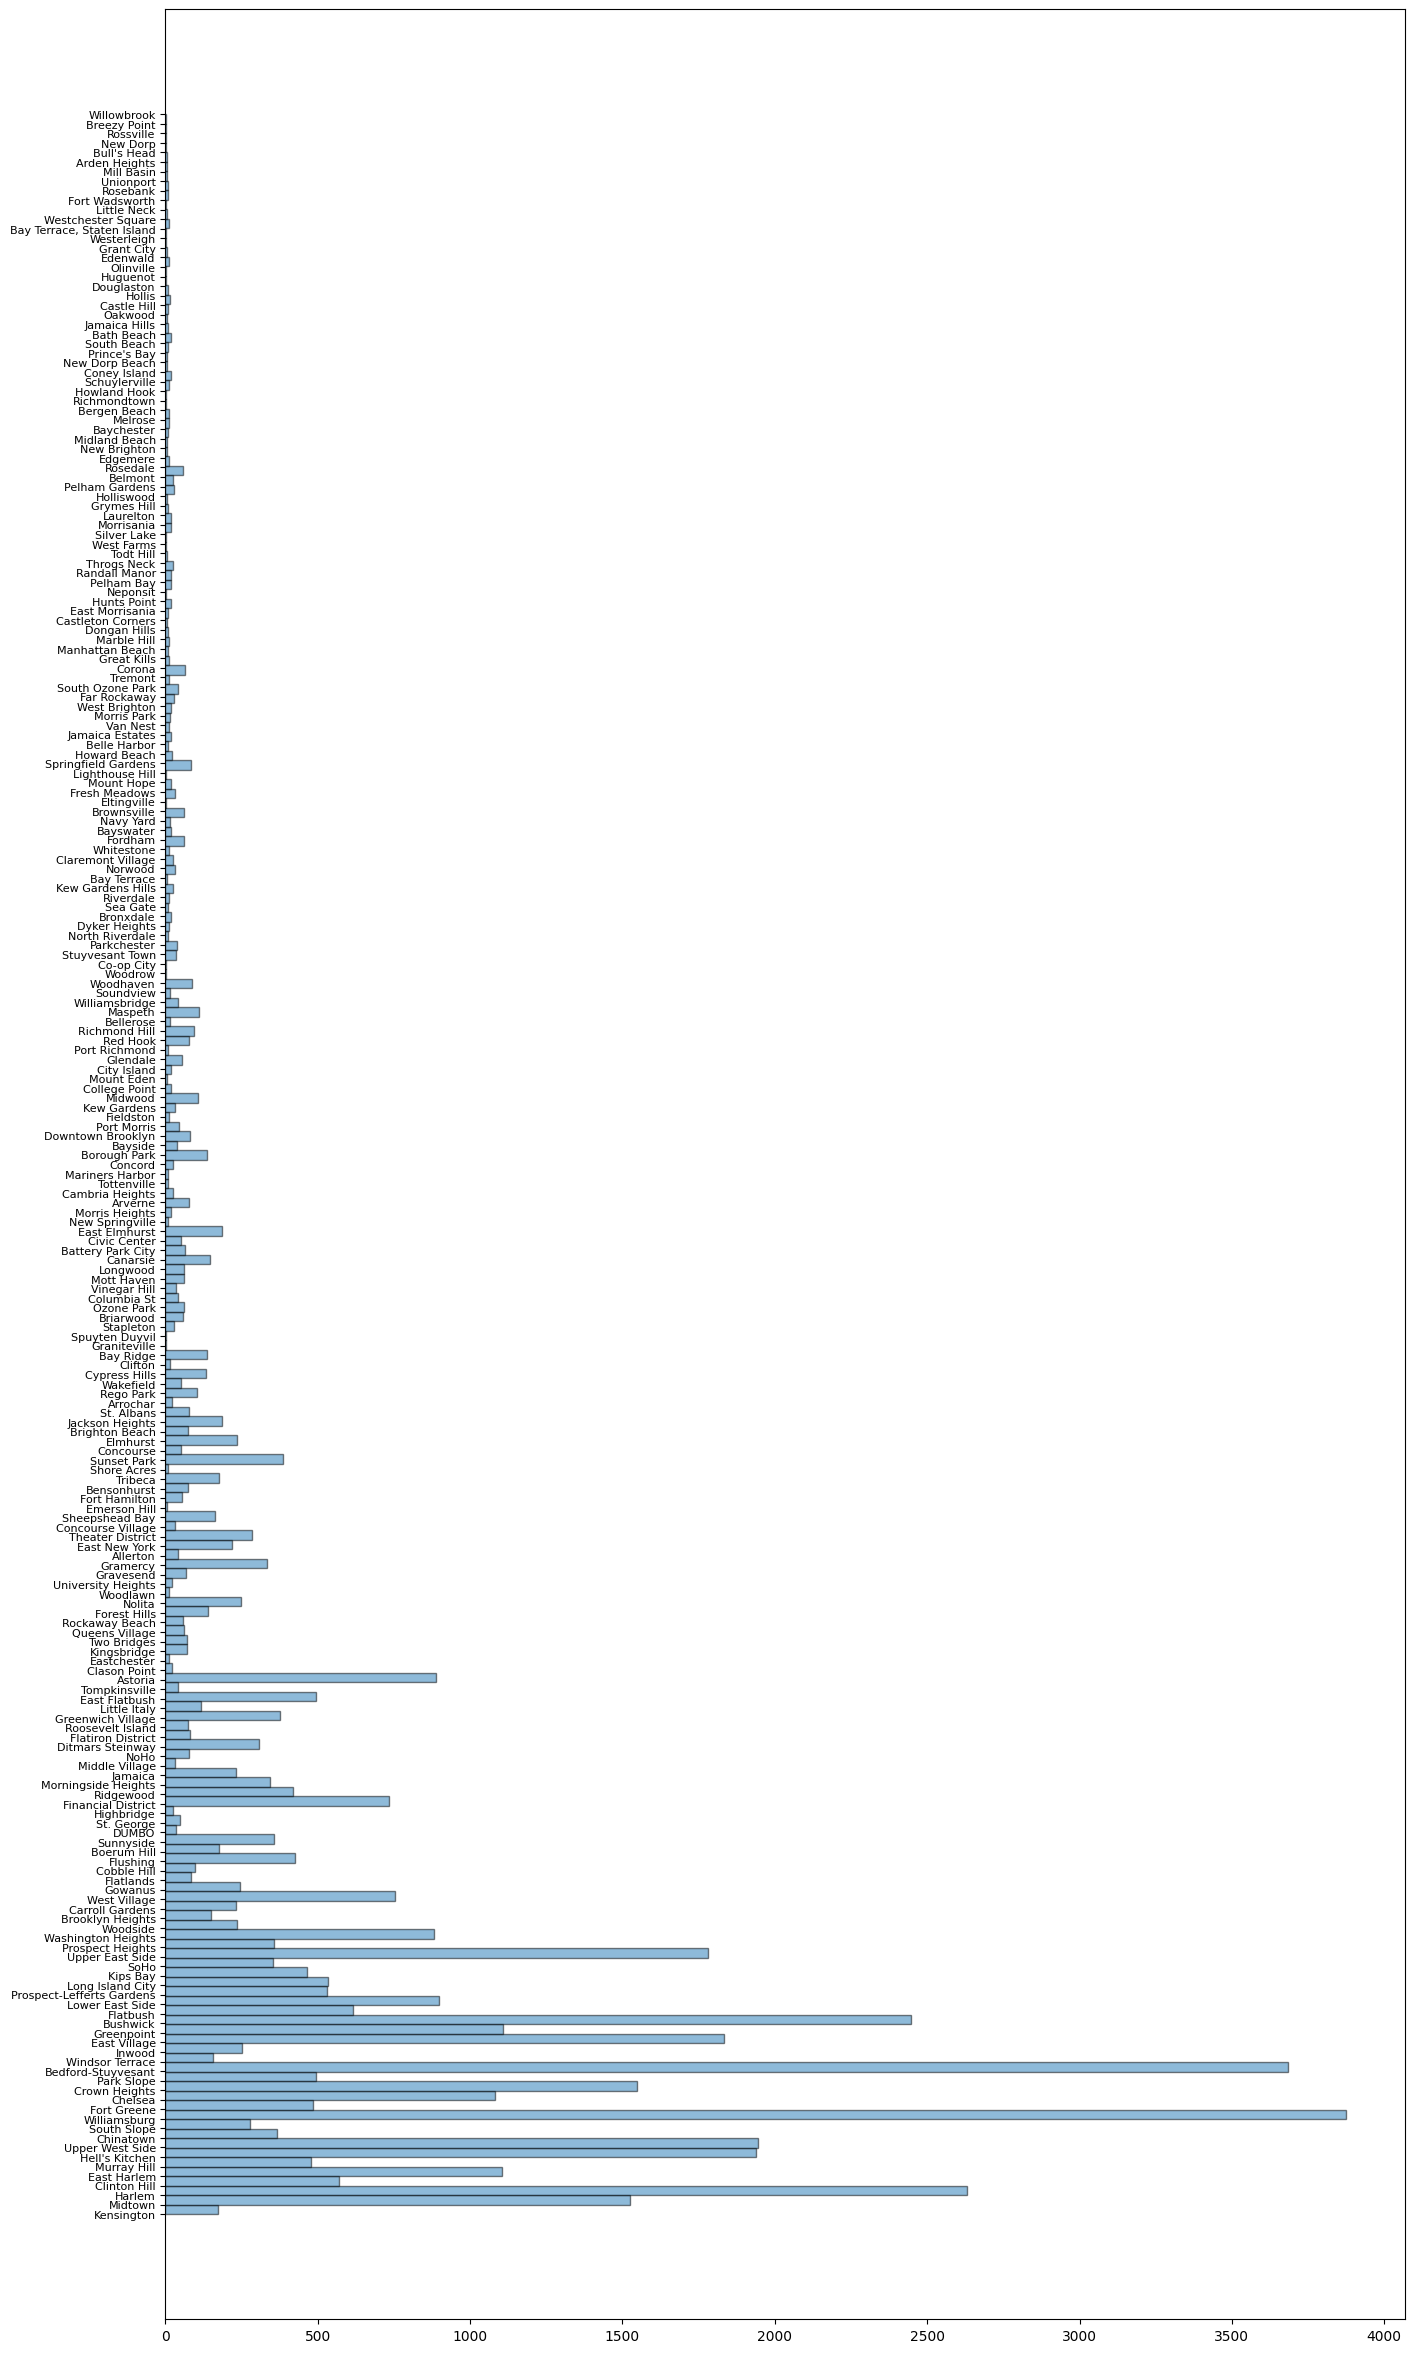

In [27]:
column = df["neighbourhood"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 30))

n, bins, patches = ax.hist(column, bins=len(column.unique()), alpha=0.5, edgecolor="black", orientation="horizontal")

plt.yticks(ha='right', fontsize=8)
plt.show()

Во всех колонках есть дисбаланс количества представителей, что вероятно обусловлено разницей в размерах и популярности каждого типа жилья, боро или района в боро. В дальнейшем возможно нужно будет увеличить количество малопредставленных категорий или заменить данные о местоположении на географические координаты.

## Подготовка данных

In [28]:
print("Total lines:", df.shape[0])
print("Columns:")
for col in df.columns:
    print(" -", col)

Total lines: 48338
Columns:
 - id
 - neighbourhood_group
 - neighbourhood
 - latitude
 - longitude
 - room_type
 - price
 - minimum_nights
 - last_review
 - reviews_per_month
 - calculated_host_listings_count
 - availability_365


Для начала попробуем обучить модель на данных без учёта координат, чтобы было референсное значение для дальнейшей работы.

In [29]:
coordinates = df[["latitude", "longitude"]]
ids = df["id"]
df = df.drop(["id", "latitude", "longitude"], axis=1)

### Преобразование категориальных данных
Колонки:
- room_type
- neighbourhood
- neighbourhood_group

In [30]:
columns = ["room_type", "neighbourhood_group", "neighbourhood"]
for col in columns:
    one_hot = pd.get_dummies(df[col], dtype=np.float32)
    df = df.join(one_hot)
df = df.drop(columns, axis=1)

## Обучение

Подобранные  процессе обучения и тестирования гиперпараметры.

In [31]:
N_ESTIMATORS = 450
MAX_DEPTH = 10

### Модель #1

Будет использоваться модель Random Forest Regression, т.к. она лучше показывает себя в сложных условиях, таких как предсказание цен для airbnb, где на цену может влиять огромное количество параметров, хотя в таблице таких параметров немного.

In [32]:
_, importance_df = train(df[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/2634122767.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _, importance_df = train(df[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 45.832096506821266
R-squared: 0.5401469802937953

On train:
Root Mean Squared Error: 42.95592513408218
R-squared: 0.604503256035648

               Feature  Importance
5      Entire home/apt    0.644104
10           Manhattan    0.100726
4     availability_365    0.049459
2    reviews_per_month    0.030764
0       minimum_nights    0.027098
..                 ...         ...
37           Bronxdale    0.000000
190        Silver Lake    0.000000
212          Unionport    0.000000
40         Bull's Head    0.000000
69          Douglaston    0.000000

[234 rows x 2 columns]


После обучения модели можно проанализировать важность каждого признака, и откинуть малозначимые так, чтобы итоговая точность предсказаний почти не снижалась

In [33]:
df_dropped = delete_unimportant(df, importance_df, 0.001)
print(df_dropped.columns)

                            Feature  Importance
5                   Entire home/apt    0.644104
10                        Manhattan    0.100726
4                  availability_365    0.049459
2                 reviews_per_month    0.030764
0                    minimum_nights    0.027098
3    calculated_host_listings_count    0.024303
1                       last_review    0.019013
227                    Williamsburg    0.018681
107                          Harlem    0.014878
219              Washington Heights    0.012751
74                      East Harlem    0.006326
140                         Midtown    0.006236
116                          Inwood    0.004090
214                 Upper East Side    0.003045
9                          Brooklyn    0.002519
164                      Park Slope    0.002471
104                      Greenpoint    0.002308
6                      Private room    0.002230
7                       Shared room    0.002227
54                     Clinton Hill    0

По итогу была удалена большая часть OHE районов в боро, что достаточно ожидаемо, но тепер есть численное подтверждение.

### Модeль #2

Здесь пробуем обучить модель на меньшем количестве параметров, и проверим как изменится точность.

In [34]:
_, importance_df = train(df_dropped[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/1226790932.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _, importance_df = train(df_dropped[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 45.89041946427151
R-squared: 0.5389758772966824

On train:
Root Mean Squared Error: 43.11603381001762
R-squared: 0.6015495089089438

                           Feature  Importance
5                  Entire home/apt    0.645093
9                        Manhattan    0.100882
4                 availability_365    0.052305
2                reviews_per_month    0.034051
0                   minimum_nights    0.028794
3   calculated_host_listings_count    0.026917
1                      last_review    0.021069
24                    Williamsburg    0.018717
16                          Harlem    0.014981
23              Washington Heights    0.012840
11                     East Harlem    0.006604
19                         Midtown    0.006321
17                          Inwood    0.004222
22                 Upper East Side    0.003324
8                         Brooklyn    0.003128
21                      Park Slope    0.002895
15                      Greenpoint

Точность уменьшилась на ~0.002, что считаю приемлемым.

### Модель #3

После удаления малозначительных параметров можем вернуть столбцы координат и проверить, как изменится точность и важность параметров.

In [35]:
df_with_location = df_dropped.join(coordinates)

_, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/1150014468.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 44.35599848887242
R-squared: 0.5692906345440351

On train:
Root Mean Squared Error: 40.129818555293674
R-squared: 0.6548315033570085

                           Feature  Importance
5                  Entire home/apt    0.594527
26                       longitude    0.135524
25                        latitude    0.098578
4                 availability_365    0.046972
2                reviews_per_month    0.027100
0                   minimum_nights    0.025453
3   calculated_host_listings_count    0.023480
9                        Manhattan    0.015748
1                      last_review    0.015651
24                    Williamsburg    0.004453
19                         Midtown    0.003563
7                      Shared room    0.002062
6                     Private room    0.002038
22                 Upper East Side    0.001406
10                    Clinton Hill    0.000715
15                      Greenpoint    0.000560
18                Long Island Cit

In [36]:
df_with_location = delete_unimportant(df_with_location, importance_df, 0.001)
print(df_with_location.columns)

                           Feature  Importance
5                  Entire home/apt    0.594527
26                       longitude    0.135524
25                        latitude    0.098578
4                 availability_365    0.046972
2                reviews_per_month    0.027100
0                   minimum_nights    0.025453
3   calculated_host_listings_count    0.023480
9                        Manhattan    0.015748
1                      last_review    0.015651
24                    Williamsburg    0.004453
19                         Midtown    0.003563
7                      Shared room    0.002062
6                     Private room    0.002038
22                 Upper East Side    0.001406
Index(['price', 'minimum_nights', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'Entire home/apt',
       'Private room', 'Shared room', 'Manhattan', 'Midtown',
       'Upper East Side', 'Williamsburg', 'latitude', 'longitude'],
      dtype='ob

Как видно из результатов обучения, учёт координат дал прирост к точности модели. Вероятно это произашло из-за того, что числовые значения дают более точную информацию о том, как местоположение помещения влияет на ценовой диапазон.

In [37]:
_, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/504624097.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 44.3523802335213
R-squared: 0.5693609002558673

On train:
Root Mean Squared Error: 40.120256226761825
R-squared: 0.6549959806180229

                           Feature  Importance
5                  Entire home/apt    0.594257
13                       longitude    0.136843
12                        latitude    0.099926
4                 availability_365    0.047182
2                reviews_per_month    0.027215
0                   minimum_nights    0.025608
3   calculated_host_listings_count    0.023757
8                        Manhattan    0.015865
1                      last_review    0.015798
11                    Williamsburg    0.004458
9                          Midtown    0.003560
7                      Shared room    0.002090
6                     Private room    0.002024
10                 Upper East Side    0.001414


После отбрасываниия малозначимых параметров, получаем незначительное уменшение точности, и как можно заметить, снова пропали колонки, сязанные с расположением помещений, что подтверждает прошлый тезис.

### Модель #4

Для дальнейшего улучшения можно попробовать добавить нелинейные признаки на основе координат, что может помочь найти нелинейные зависимости между координатами.

In [38]:
location_features = df_with_location[['latitude', 'longitude']]
df_with_location_2 = df_with_location.drop(["latitude", "longitude"], axis=1)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

poly_features = poly.fit_transform(location_features)

poly_feature_names = poly.get_feature_names_out(['latitude', 'longitude'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

df_with_location_2 = df_with_location_2.join(poly_df)

In [39]:
_, importance_df = train(df_with_location_2[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/2641805185.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _, importance_df = train(df_with_location_2[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 47.529410945556045
R-squared: 0.5054565444434092

On train:
Root Mean Squared Error: 43.80024254712954
R-squared: 0.5888031399174227

                           Feature  Importance
5                  Entire home/apt    0.655207
8                        Manhattan    0.102463
4                 availability_365    0.046862
3   calculated_host_listings_count    0.032278
2                reviews_per_month    0.031154
0                   minimum_nights    0.028161
11                    Williamsburg    0.019000
1                      last_review    0.016723
15              latitude longitude    0.014982
13                       longitude    0.010997
16                     longitude^2    0.010758
9                          Midtown    0.008730
14                      latitude^2    0.008508
12                        latitude    0.008308
7                      Shared room    0.002360
6                     Private room    0.002341
10                 Upper East Sid

Гипотеза не потвердилась, судя по всему нелинейные зависимости отсутвуют. Расширять таблицу таким образом неэффективно.

### Модель #5

Ещё можно попробовать добавить кластеризацию географических координат для дополнительного учёта местоположения помещения.

In [40]:
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
df_with_location["cluster"] = kmeans.fit_predict(scaled_coordinates)
mappings = dict([(i, f"cluster_{i}") for i in range(10)])

df_with_location["cluster"] = df_with_location["cluster"].map(mappings)

cluster_df = pd.get_dummies(df_with_location["cluster"], dtype=np.float32)
df_with_location = df_with_location.drop(["cluster"], axis=1)

df_with_location = df_with_location.join(cluster_df)

Скейлим координаты, т.к. K-means чувствителен к масштабу. Кластеризируем координаты (точки). Кодируем кластера через OHE и добавляем их в таблицу.

In [41]:
_, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/504624097.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 44.33740563184068
R-squared: 0.5696516427292527

On train:
Root Mean Squared Error: 40.09766955484495
R-squared: 0.6553843280435898

                           Feature  Importance
5                  Entire home/apt    0.594017
13                       longitude    0.136143
12                        latitude    0.098275
4                 availability_365    0.047089
2                reviews_per_month    0.027232
0                   minimum_nights    0.025477
3   calculated_host_listings_count    0.023589
8                        Manhattan    0.015774
1                      last_review    0.015730
11                    Williamsburg    0.004439
9                          Midtown    0.003475
6                     Private room    0.002148
7                      Shared room    0.001963
16                       cluster_2    0.001659
10                 Upper East Side    0.001048
23                       cluster_9    0.000403
17                       cluster_3

Получили незначительное изменение точности, надо проверить, как учёт кластеров повлиял на важность других признаков.

In [42]:
df_with_location = delete_unimportant(df_with_location, importance_df, 0.001)
print(df_with_location.columns)

                           Feature  Importance
5                  Entire home/apt    0.594017
13                       longitude    0.136143
12                        latitude    0.098275
4                 availability_365    0.047089
2                reviews_per_month    0.027232
0                   minimum_nights    0.025477
3   calculated_host_listings_count    0.023589
8                        Manhattan    0.015774
1                      last_review    0.015730
11                    Williamsburg    0.004439
9                          Midtown    0.003475
6                     Private room    0.002148
7                      Shared room    0.001963
16                       cluster_2    0.001659
10                 Upper East Side    0.001048
Index(['price', 'minimum_nights', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'Entire home/apt',
       'Private room', 'Shared room', 'Manhattan', 'Midtown',
       'Upper East Side', 'Williamsb

In [43]:
model, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)
print(importance_df)

/tmp/ipykernel_24880/1342721983.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model, importance_df = train(df_with_location[price_mask], N_ESTIMATORS, MAX_DEPTH)


On test:
Root Mean Squared Error: 44.32970490536078
R-squared: 0.5698011195490249

On train:
Root Mean Squared Error: 40.103804723181774
R-squared: 0.6552788637145945

                           Feature  Importance
5                  Entire home/apt    0.594117
13                       longitude    0.136649
12                        latitude    0.099112
4                 availability_365    0.047161
2                reviews_per_month    0.027305
0                   minimum_nights    0.025627
3   calculated_host_listings_count    0.023588
8                        Manhattan    0.015808
1                      last_review    0.015773
11                    Williamsburg    0.004459
9                          Midtown    0.003482
6                     Private room    0.002103
7                      Shared room    0.002024
14                       cluster_2    0.001733
10                 Upper East Side    0.001059


Сохраняем предсказания для всего изначального набора данных.

In [50]:
predict = model.predict(df_with_location[price_mask].drop(["price"], axis=1))
results = pd.DataFrame({"predicted_price": predict})
results["id"] = ids

results.to_csv("predicted.csv")

/tmp/ipykernel_24880/2033029087.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predict = model.predict(df_with_location[price_mask].drop(["price"], axis=1))


После удаления малозначимых признаков видим, что один кластеризация действительно не оказывает существенного влияния, следовательно чистые координаты уже дают достаточно информации и зависимости цены от местоположения помещения.

## Итоги

Можно отметить, что наиболее существенно влиябщими на цену оказались 3 параметра: Тип жилья "Полная аренда дома/квартиры", долгота и широта.
Такой исход можно объясниить:
- Тип жилья: Аренда целого астного дома или квартиры значительно повышает цену по сравнению с другими двумя типами, комната и "совместная" комната.
- Координаты: Расположение помещения тоже оказывает существенное влияние на цену, т.к. это сразу создаёт много факторов для повышени/понижения цен. Например трущёбы или, наоборот, центр города занимают определённую площадь, котрой многое может влиять на цену жилья, но и сама репутация данной местности. Преобладание же именно долготы над широтой объясняется тем, что протяжённость Нью-Йорка вдоль долготы больше, чем вдоль широты.

В целом задача предсказания цен на аренду жилья содержит огромное количество переменных, которые необходимо учитывать. Помимо представленных в таблице параметров могут влиять такие вещи как сезон (например летом цены могут повышаться из-за туризма), на какую целеву аудиторию ориентирован арендодатель (например если предполагается длительная аренда семьями с детьми, то важно наличие детских садов, школ и т.п., а наличие рядом скажем пляжа или вида из окна менее важно, а вот при ориентировании на туристов, наоборот), время с последнего ремонта (или его качество от 0 до 1, но это оценить уже сильно сложнее, да и эту информацию ещё надо найти), с какой целю чаще всего арендуют это помещение (туризм, постоянное проживание, командировки и т.п.).
Среди представленных данных могла бы быть полезна дополнительная информация: рейтинг жилья (например по результатом отзывов), на сколько дней в среднем арендуют это жильё, для каких целей большинство людей арендует это жильё.

В предоставленных данных есть сильные проблемы с балансом во многих параметрах, есть крупные выбросы в целевом столбце. В качестве дальнейшего улучшения можно попробовать сбалансировать несбалансированные данные с ипользованием методов из scikit-learn (например генерацию на основе линейной интерполяции значений), также имеет смысл расширить информацию о местоположении, например посчитать расстояние до ближайших остановок/станций общественного странспорта, выделить не только такие группы как боро или районы в боро, а такие зоны как бизнесцентры, торговые центры боро, туристические центры и т.п. Также можно попробовать взять модели вроде XGBoost, они менее интерпретируемые, но могут дать прирост к качеству работы моделей.